### Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "Ответ:".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.


In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом "bikes_rent.csv", в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции pandas.read_csv в переменную df. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:


In [2]:
# Ваш код
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('14 bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):

season: 1 - весна, 2 - лето, 3 - осень, 4 - зима

yr: 0 - 2011, 1 - 2012

mnth: от 1 до 12

holiday: 0 - нет праздника, 1 - есть праздник

weekday: от 0 до 6

workingday: 0 - нерабочий день, 1 - рабочий день

weathersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)

temp: температура в Цельсиях

atemp: температура по ощущениям в Цельсиях

hum: влажность

windspeed(mph): скорость ветра в милях в час

windspeed(ms): скорость ветра в метрах в секунду

cnt: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных


### Блок 1. Ответьте на вопросы :

1.	Каков характер зависимости числа прокатов от месяца? ответ:
Линейная зависимость

2.	Укажите один или два признака, от которых число прокатов скорее всего зависит линейно ответ:температура, погода 




Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


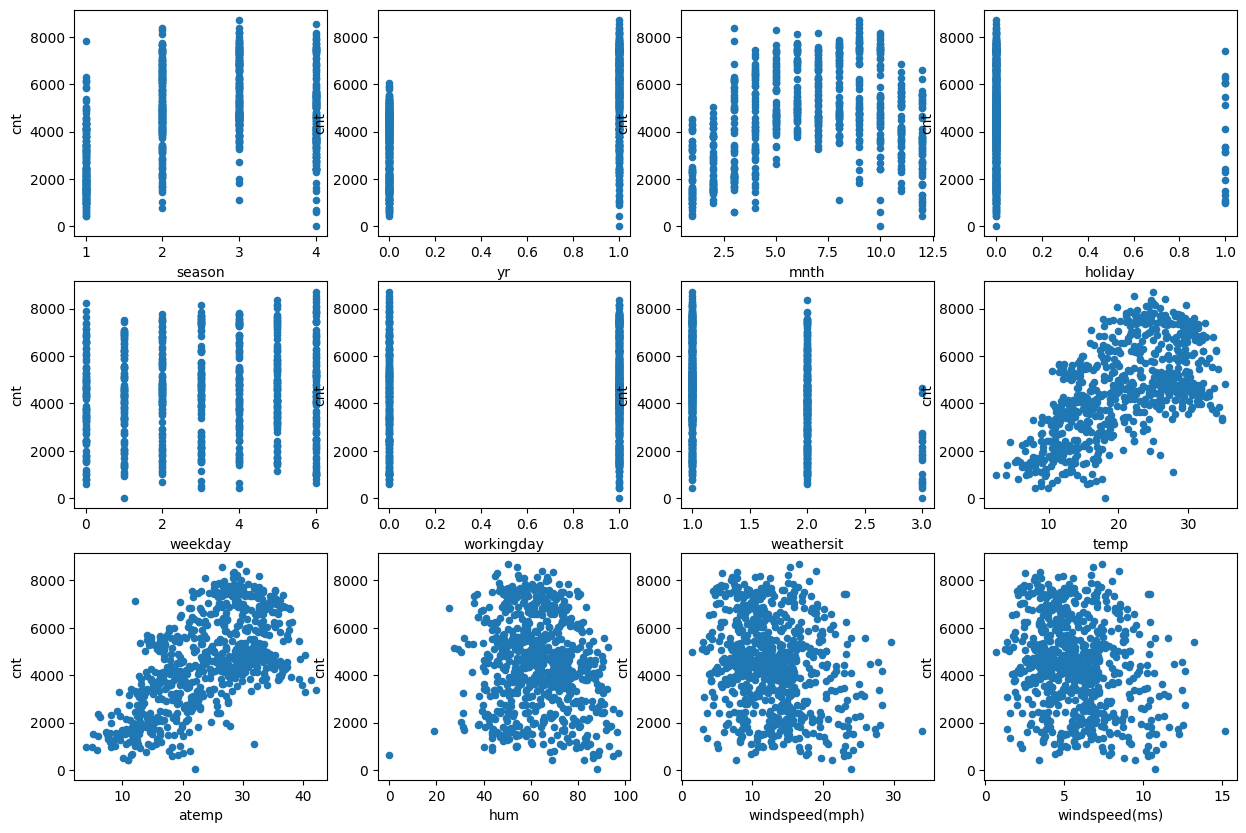

In [3]:
# Код 1.1 
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, 'cnt', subplots=True, kind='scatter', ax=axes[idx // 4, idx % 4])


target = df['cnt'] # получаем целевую переменную
correlations = df.drop(columns=['cnt']).corrwith(target) # Вычисление корреляций между признаками и целевой переменной (для этого удалили в date целевой столбец)
print(correlations)

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.
По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.


In [4]:
# Код 1.2 
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), win dspeed(ms) и cnt
# с помощью метода corr:
correlation_matrix = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
print(correlation_matrix)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.


In [5]:
#Код 1.3 
# Выведите средние признаков
means = df.mean()
print(means)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.



In [6]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [7]:
# Масштабирование признаков
scaled_features = scale(df.drop(columns=['cnt']))
# Создание DataFrame для X с масштабированными признаками и включением целевой переменной
X = pd.DataFrame(scaled_features, columns=df.columns[:-1])
# Создание Series дя y с целевой переменной
y = df['cnt']
# Перемешивание признаков и целевой переменной
shuffled_data = shuffle(X.assign(cnt=y), random_state=42)

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
# Код 2.1 
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса моде ли
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенн ой в язык python
# Названия признаков хранятся в переменной df.columns

# Создание объекта линейного регрессора
regressor = LinearRegression()
regressor.fit(shuffled_data.drop(columns=['cnt']), shuffled_data['cnt']) # Обучение регрессора на всех данных
weights = list(zip(df.columns[:-1], regressor.coef_))
for feature, weight in weights:
    print(f'{feature}: {weight}')     # Вывод весов модели



season: 570.8635830291413
yr: 1021.969581295517
mnth: -141.30032213605412
holiday: -86.75863713613849
weekday: 137.22395350413993
workingday: 56.39092261055161
weathersit: -330.22842905673537
temp: 367.46645535537584
atemp: 585.5631143944084
hum: -145.6135356354845
windspeed(mph): 12454942247374.432
windspeed(ms): -12454942247572.893


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.


С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Решение проблемы мультиколлинеарности состоит в регуляризации линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации α. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.



In [10]:
from sklearn.linear_model import Lasso, Ridge

In [11]:
# Код 2.2 
# Обучите линейную модель с L1-регуляризацией
# Создание объекта Lasso регрессора
lasso_regressor = Lasso()
lasso_regressor.fit(shuffled_data.drop(columns=['cnt']), shuffled_data['cnt'])# Обучение Lasso регрессора
print("\nLasso регрессор:")
weights_lasso = list(zip(df.columns[:-1], lasso_regressor.coef_))
for feature, weight in weights_lasso:   # Вывод весов Lasso регрессора
    print(f'{feature}: {weight}')


Lasso регрессор:
season: 560.2416160308866
yr: 1019.4634940657196
mnth: -128.73062703678727
holiday: -86.15278133371102
weekday: 137.34789390496314
workingday: 55.212370641356536
weathersit: -332.3698569623485
temp: 376.3632362096941
atemp: 576.5307935045556
hum: -144.1291550034861
windspeed(mph): -197.13968940248392
windspeed(ms): -2.805156079453976e-08


In [12]:
# Код 2.3 
# Обучите линейную модель с L2-регуляризацией

ridge_regressor = Ridge()
ridge_regressor.fit(shuffled_data.drop(columns=['cnt']), shuffled_data['cnt'])# Обучение Ridge регрессора
# Вывод весов Ridge регрессора
print("Ridge регрессор:")
weights_ridge = list(zip(df.columns[:-1], ridge_regressor.coef_))
for feature, weight in weights_ridge:
    print(f'{feature}: {weight}')



Ridge регрессор:
season: 563.0645722520193
yr: 1018.9483787875307
mnth: -131.87332028247866
holiday: -86.74609799709202
weekday: 138.00511117871915
workingday: 55.90311037506482
weathersit: -332.34978849907253
temp: 386.45788919191745
atemp: 566.3470470600578
hum: -145.07132729867263
windspeed(mph): -99.25944108181756
windspeed(ms): -99.25944115431525


#### Блок 2. 

Поясните, каким образом введение регуляризации решает проблему с весами и  мультиколлинеарностью.

Ваш ответ: Регуляризация вводит дополнительный член в функцию потерь во время обучения модели. Этот дополнительный член штрафует модель за слишком большие значения весов (коэффициентов), что помогает предотвратить переобучение и справиться с проблемой мультиколлинеарности.
В нашем случае для похожих переменных(ветер), которые полуичлись противположные, хотя оба растут одинаково,
но с помощью регуляризации они становсят в одно направлении, причем можно заметить что их суммарный вес стал 200 ,(до этого получался 0)
интересно что в первом вес идет на один из признако, а во втором делится пополам




#### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации α (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).


In [13]:
# Код 3.1 
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число ре грессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
# Обучение регрессоров Lasso и Ridge для различных значений alpha
for i, alpha in enumerate(alphas):
    # Обучение Lasso регрессора
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso[i] = lasso_regressor.coef_
    
    # Обучение Ridge регрессора
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge[i] = ridge_regressor.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:



Text(0.5, 1.0, 'Ridge')

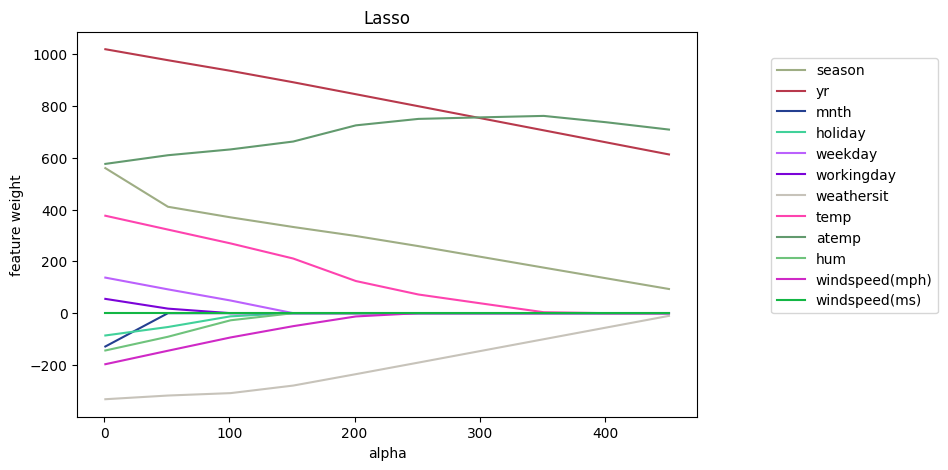

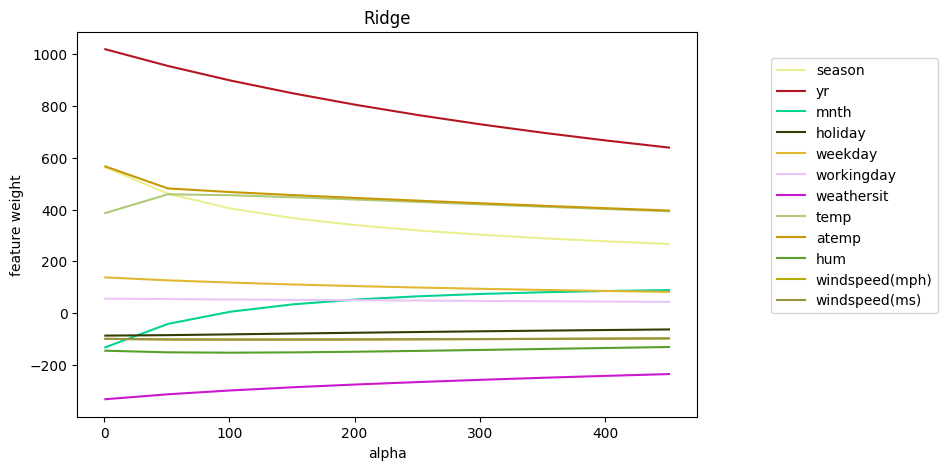

In [14]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3)) 
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight") 
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3)) 
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight") 
plt.title("Ridge")


Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

##### Блок 3. Ответьте на вопросы 

1.	Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же                              alpha?
Ответ: ridge
2.	Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
Ответ: то все веса будут стремиться к нулю, и некоторые из них могут даже стать точно нулевыми. Это происходит из-за того, что при очень большом значении alpha штраф за большие значения весов становится настолько сильным, что модель стремится минимизировать сумму абсолютных значений весов, что приводит к уменьшению или даже исключению некоторых признаков.
3.	Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении      alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3. 
Ответ:да. можно на втором вопросе расписано, а ridge нет, он скорее погашает оба признака сразу
4.	Какой из регуляризаторов подойдет для отбора неинформативных признаков? Ответ:Lasso, думаю пояснять уже не надо






###### Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, LassoCV, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную mse_path_, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс- валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha_ будет храниться выбранное значение параметра регуляризации, а в coef_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.



In [15]:
from sklearn.linear_model import LassoCV

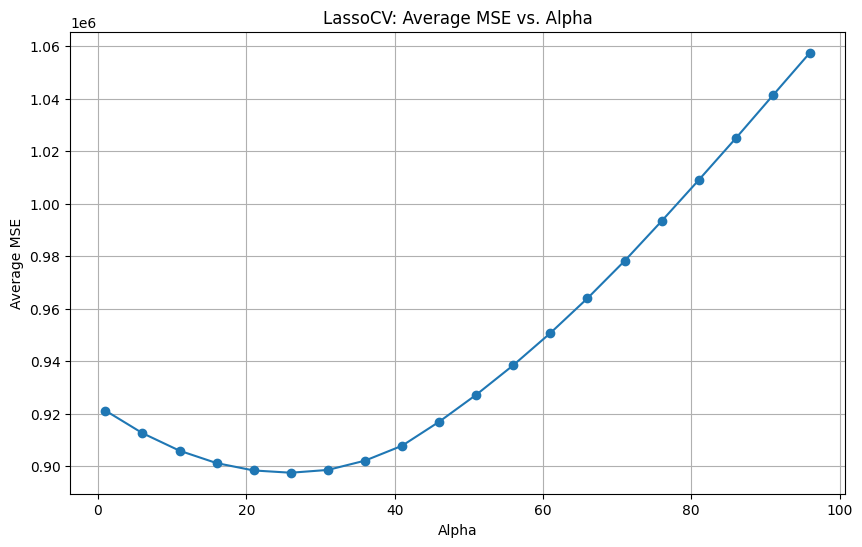

Выбранное значение alpha: 26

Пары 'признак-коэффициент':
season: 431.50501463394625
yr: 997.59495798591
mnth: -0.0
holiday: -71.47585346746392
weekday: 113.41239026287371
workingday: 36.8313553149545
weathersit: -323.67910842163866
temp: 348.3123978409406
atemp: 599.3914909821132
hum: -122.41739716302776
windspeed(mph): -170.44942053622952
windspeed(ms): -2.2572722875547534e-08


In [16]:
# Код 3.2 
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha.
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора к оэффициентов
alphas = np.arange(1, 100, 5)
# Создание регрессора LassoCV
lasso_cv_regressor = LassoCV(alphas=alphas, cv=3)

# Обучение регрессора на данных
lasso_cv_regressor.fit(X, y)

# Получение средних значений MSE по кросс-валидации для каждого значения alpha
mse_mean = np.mean(lasso_cv_regressor.mse_path_, axis=1)

# Построение графика усредненного MSE в зависимости от alpha
plt.figure(figsize=(10, 6))
plt.plot(lasso_cv_regressor.alphas_, mse_mean, marker='o', linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Average MSE')
plt.title('LassoCV: Average MSE vs. Alpha')
plt.grid(True)
plt.show()

# Вывод выбранного alpha
print("Выбранное значение alpha:", lasso_cv_regressor.alpha_)

# Вывод пар "признак-коэффициент" для обученного вектора коэффициентов
print("\nПары 'признак-коэффициент':")
for feature, coef in zip(df.columns[:-1], lasso_cv_regressor.coef_):
    print(f"{feature}: {coef}")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали                                   alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Alpha values corresponding to minimum MSE for each fold:
Fold 1: 56
Fold 2: 41
Fold 3: 1


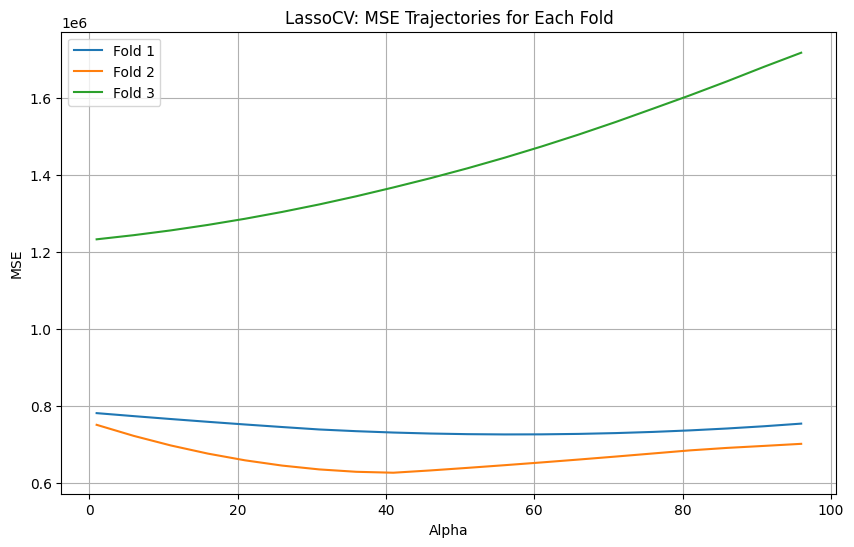

In [17]:
# Код 3.3 
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть п о столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
# Получение индекса минимального значения MSE для каждого разбиения
min_alpha_indices = np.argmin(lasso_cv_regressor.mse_path_, axis=0)

# Вывод значений alpha, соответствующих минимумам MSE на каждом разбиении
print("Alpha values corresponding to minimum MSE for each fold:")
for i, index in enumerate(min_alpha_indices):
    print(f"Fold {i+1}: {lasso_cv_regressor.alphas_[index]}")

# Визуализация столбцов mse_path_ на трех отдельных графиках
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(lasso_cv_regressor.alphas_, lasso_cv_regressor.mse_path_[:, i], label=f'Fold {i+1}')

plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('LassoCV: MSE Trajectories for Each Fold')
plt.legend()
plt.grid(True)
plt.show()


На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки.
При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.



##### Блок 4. Ответьте на вопросы:

1.	В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды,
Ответ: atemp, year,temp, season; заметно; да, логично
2.	Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
Ответ:weathersit, windspeed(mph),hum; видна; логично
3.	Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
Ответ:mnth, windspeed(ms), да верно они не так важны как другие, напирмер windspeed(ms) дублирует другое поле которое также влияет и нет смысла хранить их обоих

###### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.
